# Sparkify 项目 Workspace
这个 Workspace 包括一个迷你的子数据集（128MB），是完整数据集（12GB）的一个子集。在将你的项目部署到云上之前，你可以自由使用 Workspace 来创建你的项目或用Spark来探索这个较小数据集。设置 Spark 集群的指南可以在选修 Spark 课程的内容里找到。

你可以依照下面的步骤进行项目的数据分析和模型搭建部分。

In [3]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import count,avg
from pyspark.ml.feature import StandardScaler
import seaborn as sns

In [4]:
# create a Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("DHSpark") \
    .getOrCreate()

# 加载和清洗数据
在这个 Workspace 中，小数据集的名称是 `mini_sparkify_event_data.json`.加载和清洗数据集，检查是否有无效或缺失数据——例如，没有userid或sessionid的数据。 

In [5]:
df = spark.read.json('mini_sparkify_event_data.json')
df.dtypes

[('artist', 'string'),
 ('auth', 'string'),
 ('firstName', 'string'),
 ('gender', 'string'),
 ('itemInSession', 'bigint'),
 ('lastName', 'string'),
 ('length', 'double'),
 ('level', 'string'),
 ('location', 'string'),
 ('method', 'string'),
 ('page', 'string'),
 ('registration', 'bigint'),
 ('sessionId', 'bigint'),
 ('song', 'string'),
 ('status', 'bigint'),
 ('ts', 'bigint'),
 ('userAgent', 'string'),
 ('userId', 'string')]

In [6]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [7]:
df.take(1)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')]

In [8]:
##查看page中有多少种
df.groupBy('page').count().show()

+--------------------+------+
|                page| count|
+--------------------+------+
|              Cancel|    52|
|    Submit Downgrade|    63|
|         Thumbs Down|  2546|
|                Home| 14457|
|           Downgrade|  2055|
|         Roll Advert|  3933|
|              Logout|  3226|
|       Save Settings|   310|
|Cancellation Conf...|    52|
|               About|   924|
| Submit Registration|     5|
|            Settings|  1514|
|               Login|  3241|
|            Register|    18|
|     Add to Playlist|  6526|
|          Add Friend|  4277|
|            NextSong|228108|
|           Thumbs Up| 12551|
|                Help|  1726|
|             Upgrade|   499|
+--------------------+------+
only showing top 20 rows



In [9]:
##查看auth中有多少种
df.groupBy('auth').count().show(100)

+----------+------+
|      auth| count|
+----------+------+
|Logged Out|  8249|
| Cancelled|    52|
|     Guest|    97|
| Logged In|278102|
+----------+------+



In [10]:
##查看level中有多少种
df.groupBy('level').count().show(100)

+-----+------+
|level| count|
+-----+------+
| free| 58338|
| paid|228162|
+-----+------+



In [11]:
##查看status中有多少种
df.groupBy('status').count().show(100)

+------+------+
|status| count|
+------+------+
|   307| 26430|
|   404|   258|
|   200|259812|
+------+------+



In [12]:
##用户总数
df.count()

286500

In [13]:
##没有userid的项
df.filter(df['userID'] == '').count()

8346

In [14]:
##没有sessionid的项
df.filter(df['sessionID'] == '').count()

0

In [15]:
## 去除userId和sessionId为空的行
df_clean = df.dropna(how = 'any', subset = ['userId', 'sessionId'])
df_clean = df.filter(df["userId"] != "")
df_clean.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [16]:
df_clean.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



# 探索性数据分析
当你使用完整数据集时，通过加载小数据集，在 Spark 中完成基础操作来实现探索性数据分析。在这个 Workspace 中，我们已经提供给你一个你可以探索的小数据集。

### 定义客户流失

在你完成初步分析之后，创建一列 `Churn` 作为模型的标签。我建议你使用 `Cancellation Confirmation` 事件来定义客户流失，该事件在付费或免费客户身上都有发生。作为一个奖励任务，你也可以深入了解 `Downgrade` 事件。

### 探索数据
你定义好客户流失后，就可以执行一些探索性数据分析，观察留存用户和流失用户的行为。你可以首先把这两类用户的数据聚合到一起，观察固定时间内某个特定动作出现的次数或者播放音乐的数量。

#### 增加新列churn

In [17]:
df_cancelled_ids = df_clean.filter(df['page'] == 'Cancellation Confirmation').select('userId').drop_duplicates()
cancelled_ids = [x["userId"] for x in df_cancelled_ids.collect()]
df_clean = df_clean.withColumn('churn', df_clean.userId.isin(cancelled_ids))

In [18]:
df_clean.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- churn: boolean (nullable = true)



### 转化为pandas

In [19]:
dcp = df_clean.toPandas()

#### 一共有多少用户

In [20]:
dcp['userId'].drop_duplicates().count()

225

In [21]:
dcp.groupby('churn')['userId'].count()
## 数据分布并不平均

churn
False    233290
True      44864
Name: userId, dtype: int64

### 性别对客户流失的影响

In [22]:
dcp.groupby(['gender','churn'])['churn'].count()

gender  churn
F       False    135410
        True      19168
M       False     97880
        True      25696
Name: churn, dtype: int64

#### 可见性别对流失有一定影响

### itemInSession对客户流失的影响

In [23]:
df_clean.groupBy('churn').avg('itemInSession').show()

+-----+------------------+
|churn|avg(itemInSession)|
+-----+------------------+
| true|109.23299304564907|
|false| 115.9888465000643|
+-----+------------------+



### level对客户流失的影响

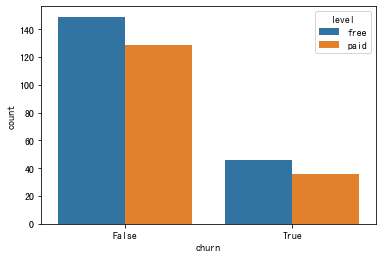

In [24]:
df_level = df_clean.dropDuplicates(["userId", "level"]).groupby("churn", "level").count().toPandas()
sns.barplot(x='churn', y='count', hue='level', data=df_level)

### 各种Page对客户流失的影响，忽略NextSong,Cancel,About,Settings

In [25]:
df_page=df_clean.select("churn", "page").where("page!='NextSong' and page!='Cancel'and page!='About'and page!='Settings'").groupby('churn', 'page').count()
df_page.show(100)

+-----+--------------------+-----+
|churn|                page|count|
+-----+--------------------+-----+
|false|       Save Settings|  252|
| true|              Logout|  553|
|false|    Submit Downgrade|   54|
| true|       Save Settings|   58|
| true|         Roll Advert|  967|
|false|          Add Friend| 3641|
|false|               Error|  220|
|false|     Add to Playlist| 5488|
| true|      Submit Upgrade|   32|
|false|           Thumbs Up|10692|
| true|Cancellation Conf...|   52|
| true|     Add to Playlist| 1038|
| true|                Home| 1672|
| true|             Upgrade|  112|
|false|         Thumbs Down| 2050|
| true|    Submit Downgrade|    9|
| true|                Help|  239|
| true|          Add Friend|  636|
|false|                Help| 1215|
|false|         Roll Advert| 2966|
| true|           Downgrade|  337|
|false|              Logout| 2673|
|false|                Home| 8410|
| true|         Thumbs Down|  496|
| true|           Thumbs Up| 1859|
|false|             

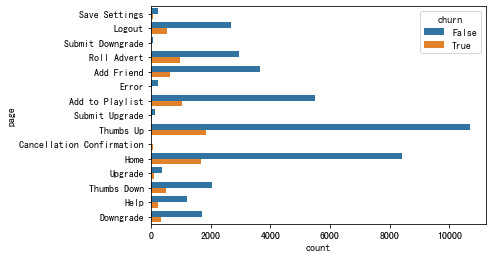

In [26]:
sns.barplot(x='count', y='page', hue='churn', orient='', data=df_page.toPandas())

# 特征工程
熟悉了数据之后，就可以构建你认为会对训练模型帮助最大的特征。要处理完整数据集，你可以按照下述步骤：
- 写一个脚本来从小数据集中提取你需要的特征
- 确保你的脚本可以拓展到大数据集上，使用之前教过的最佳实践原则
- 在完整数据集上运行你的脚本，按运行情况调试代码

如果是在教室的 workspace，你可以直接用里面提供的小数据集来提取特征。确保当你开始使用 Spark 集群的时候，把上述的成果迁移到大数据集上。

### 经观察，选出：性别，itemInSession，是否免费，点赞，踩，添加好友数，添加播放列表数，降级数这几个特征

#### 性别

In [27]:
df_gender = df_clean.select(['userId', 'gender']).dropDuplicates(['userId']).sort('userId')
df_gender = df_gender.replace(['M', 'F'], ['1', '0'], 'gender')

#### itemInSession 

In [28]:
df_item = df_clean.groupby('userId').agg(avg(df_clean.itemInSession).alias('itemInSession')).sort('userId')
df_item.show(5)

+------+------------------+
|userId|     itemInSession|
+------+------------------+
|    10|146.23899371069183|
|   100| 89.31487243310517|
|100001|28.513368983957218|
|100002|  83.4770642201835|
|100003| 40.65384615384615|
+------+------------------+
only showing top 5 rows



#### 是否免费用户

In [29]:
df_level = df_clean.select(['userId', 'level']).dropDuplicates(['userId']).sort('userId')
df_level = df_level.replace(['paid', 'free'], ['1', '0'], 'level')
df_level.show(5)

+------+-----+
|userId|level|
+------+-----+
|    10|    1|
|   100|    1|
|100001|    0|
|100002|    1|
|100003|    0|
+------+-----+
only showing top 5 rows



#### 点赞

In [30]:
df_up = df_clean.filter(df_clean.page == 'Thumbs Up').groupby('userId').agg(count(df_clean.page).alias('thumbsUps')).sort('userId')
df_up.show(5)

+------+---------+
|userId|thumbsUps|
+------+---------+
|    10|       37|
|   100|      148|
|100001|        8|
|100002|        5|
|100003|        3|
+------+---------+
only showing top 5 rows



#### 踩

In [31]:
df_down = df_clean.filter(df_clean.page == 'Thumbs Down').groupby('userId').agg(count(df_clean.page).alias('thumbsDowns')).sort('userId')
df_down.show(5)

+------+-----------+
|userId|thumbsDowns|
+------+-----------+
|    10|          4|
|   100|         27|
|100001|          2|
|100004|         11|
|100005|          3|
+------+-----------+
only showing top 5 rows



#### 添加好友数

In [32]:
df_frn = df_clean.filter(df_clean.page == 'Add Friend').groupby('userId').agg(count(df_clean.page).alias('friends')).sort('userId')
df_frn.show(5)

+------+-------+
|userId|friends|
+------+-------+
|    10|     12|
|   100|     49|
|100001|      2|
|100002|      1|
|100004|     19|
+------+-------+
only showing top 5 rows



#### 添加播放列表数

In [33]:
df_pl = df_clean.filter(df_clean.page == 'Add to Playlist').groupby('userId').agg(count(df_clean.page).alias('playlist')).sort('userId')
df_pl.show(5)

+------+--------+
|userId|playlist|
+------+--------+
|    10|       9|
|   100|      61|
|100001|       3|
|100002|       5|
|100003|       2|
+------+--------+
only showing top 5 rows



#### 降级数

In [34]:
df_dg = df_clean.filter(df_clean.page == 'Downgrade').groupby('userId').agg(count(df_clean.page).alias('downgrade')).sort('userId')
df_dg.show(5)

+------+---------+
|userId|downgrade|
+------+---------+
|    10|        7|
|   100|       30|
|100002|        2|
|100004|       10|
|100007|        7|
+------+---------+
only showing top 5 rows



#### 合为一个DATAFRAME

In [35]:
features = df_clean.select(['userId', 'churn']).dropDuplicates(['userId']).sort('userId')
for f in [df_gender,df_item, df_level, df_up, df_down, df_frn, df_pl, df_dg]:
    features = features.join(f, 'userId')

In [36]:
features.printSchema()

root
 |-- userId: string (nullable = true)
 |-- churn: boolean (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: double (nullable = true)
 |-- level: string (nullable = true)
 |-- thumbsUps: long (nullable = false)
 |-- thumbsDowns: long (nullable = false)
 |-- friends: long (nullable = false)
 |-- playlist: long (nullable = false)
 |-- downgrade: long (nullable = false)



In [37]:
features.dtypes

[('userId', 'string'),
 ('churn', 'boolean'),
 ('gender', 'string'),
 ('itemInSession', 'double'),
 ('level', 'string'),
 ('thumbsUps', 'bigint'),
 ('thumbsDowns', 'bigint'),
 ('friends', 'bigint'),
 ('playlist', 'bigint'),
 ('downgrade', 'bigint')]

#### 由于执行速度太慢，故降维，去掉itemInSession

In [38]:
features = features.drop('itemInSession')
features.toPandas().describe()

,thumbsUps,thumbsDowns,friends,playlist,downgrade
count,152.000000,152.000000,152.000000,152.000000,152.000000
mean,77.500000,15.368421,26.217105,40.486842,13.493421
std,69.418397,13.835210,21.409572,34.148485,12.051213
min,5.000000,1.000000,1.000000,3.000000,1.000000
25%,31.500000,6.000000,13.000000,15.750000,5.000000
50%,56.500000,12.000000,22.000000,33.000000,10.000000
75%,95.000000,21.000000,32.000000,54.750000,18.250000
max,437.000000,75.000000,143.000000,240.000000,73.000000


In [39]:
features.show(1)

+------+-----+------+-----+---------+-----------+-------+--------+---------+
|userId|churn|gender|level|thumbsUps|thumbsDowns|friends|playlist|downgrade|
+------+-----+------+-----+---------+-----------+-------+--------+---------+
|200002|false|     1|    0|       21|          6|      4|       8|        5|
+------+-----+------+-----+---------+-----------+-------+--------+---------+
only showing top 1 row



# 建模
将完整数据集分成训练集、测试集和验证集。测试几种你学过的机器学习方法。评价不同机器学习方法的准确率，根据情况调节参数。根据准确率你挑选出表现最好的那个模型，然后报告在训练集上的结果。因为流失顾客数据集很小，我建议选用 F1 score 作为优化指标。

In [40]:
features = features.drop("userId")

In [41]:
for c in features.columns[:]:
    features = features.withColumn(c, features[c].cast('float'))
features.dtypes

[('churn', 'float'),
 ('gender', 'float'),
 ('level', 'float'),
 ('thumbsUps', 'float'),
 ('thumbsDowns', 'float'),
 ('friends', 'float'),
 ('playlist', 'float'),
 ('downgrade', 'float')]

In [42]:
Cols = features.columns[1:]
Cols

['gender',
 'level',
 'thumbsUps',
 'thumbsDowns',
 'friends',
 'playlist',
 'downgrade']

In [43]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression,RandomForestClassifier,LinearSVC
from pyspark.ml.feature import Normalizer, MinMaxScaler, VectorAssembler, StringIndexer
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator,MulticlassClassificationEvaluator
from sklearn.metrics import f1_score, recall_score, precision_score

In [44]:
# standerscaler归一化向量
assembler = VectorAssembler(inputCols=Cols, outputCol="NFeatures")
features_scaled = assembler.transform(features)
scaler = MinMaxScaler(inputCol="NFeatures", outputCol="features")
features_scaled = scaler.fit(features_scaled).transform(features_scaled)
indexer = StringIndexer(inputCol = 'churn', outputCol = 'label')

In [45]:
features_scaled.head(1)

[Row(churn=0.0, gender=1.0, level=0.0, thumbsUps=21.0, thumbsDowns=6.0, friends=4.0, playlist=8.0, downgrade=5.0, NFeatures=DenseVector([1.0, 0.0, 21.0, 6.0, 4.0, 8.0, 5.0]), features=DenseVector([1.0, 0.0, 0.037, 0.0676, 0.0211, 0.0211, 0.0556]))]

#### 把数据集分解为测试和训练集

In [46]:
train, test = features.randomSplit([0.8, 0.2], seed = 42)

In [47]:
train.show(1)

+-----+------+-----+---------+-----------+-------+--------+---------+
|churn|gender|level|thumbsUps|thumbsDowns|friends|playlist|downgrade|
+-----+------+-----+---------+-----------+-------+--------+---------+
|  0.0|   1.0|  0.0|     21.0|        6.0|    4.0|     8.0|      5.0|
+-----+------+-----+---------+-----------+-------+--------+---------+
only showing top 1 row



### 调参前先预测一下

#### 归一化后数据拆分

In [49]:
train_scaled, test_scaled = features_scaled.randomSplit([0.8, 0.2], seed = 42)

In [53]:
pre_evaluator = MulticlassClassificationEvaluator(labelCol="churn")

#### 逻辑回归

In [54]:
pre_lr = LogisticRegression(labelCol="churn", featuresCol="features")
pre_lr_model = pre_lr.fit(train_scaled)
pre_lr_predict = pre_lr_model.transform(test_scaled)
pre_lr_accuracy = pre_evaluator.evaluate(pre_lr_predict, {pre_evaluator.metricName: "accuracy"})
pre_lr_f1score = pre_evaluator.evaluate(pre_lr_predict, {pre_evaluator.metricName: "f1"})
print('Logistic Regression Metrics:')
print('Accuracy: {}'.format(pre_lr_accuracy))
print('F-1 Score:{}'.format(pre_lr_f1score))

Logistic Regression Metrics:
Accuracy: 0.5666666666666667
F-1 Score:0.5589603283173735


#### SVM

In [56]:
pre_svm = LinearSVC(labelCol="churn", featuresCol="features")
pre_svm_model = pre_svm.fit(train_scaled)
pre_svm_predict = pre_svm_model.transform(test_scaled)
pre_svm_accuracy = pre_evaluator.evaluate(pre_svm_predict, {pre_evaluator.metricName: "accuracy"})
pre_svm_f1score = pre_evaluator.evaluate(pre_svm_predict, {pre_evaluator.metricName: "f1"})
print('Linear SVM Metrics:')
print('Accuracy: {}'.format(pre_svm_accuracy))
print('F-1 Score:{}'.format(pre_svm_f1score))

Logistic Regression Metrics:
Accuracy: 0.7
F-1 Score:0.5764705882352941


#### 随机森林

In [57]:
pre_rf = RandomForestClassifier(labelCol="churn", featuresCol="features")
pre_rf_model = pre_rf.fit(train_scaled)
pre_rf_predict = pre_rf_model.transform(test_scaled)
pre_rf_accuracy = pre_evaluator.evaluate(pre_rf_predict, {pre_evaluator.metricName: "accuracy"})
pre_rf_f1score = pre_evaluator.evaluate(pre_rf_predict, {pre_evaluator.metricName: "f1"})
print('Random Forest Metrics:')
print('Accuracy: {}'.format(pre_rf_accuracy))
print('F-1 Score:{}'.format(pre_rf_f1score))

Logistic Regression Metrics:
Accuracy: 0.6666666666666666
F-1 Score:0.6041666666666667


#### 特征重要性排序，可见点踩ThumbsDowns最重要

In [58]:
pre_rf_model.featureImportances

SparseVector(7, {0: 0.0166, 1: 0.0358, 2: 0.246, 3: 0.2327, 4: 0.1905, 5: 0.1691, 6: 0.1091})

## 网格调参加管道

In [90]:
# 定义classifiers:逻辑回归，线性SVM，随机森林
lr_classifier = LogisticRegression(maxIter=5)
svm_classifier = LinearSVC(maxIter=5)
rf_classifier = RandomForestClassifier()

In [91]:
# 定义 pipelines
lr_pipeline = Pipeline(stages=[assembler, scaler, indexer, lr_classifier]);
svm_pipeline = Pipeline(stages=[assembler, scaler,indexer, svm_classifier]);
rf_pipeline = Pipeline(stages=[assembler, scaler,indexer, rf_classifier]);

In [92]:
# 定义 param grids，
lr_paramGrid = ParamGridBuilder() \
   .addGrid(lr_classifier.regParam, [0.0, 0.1, 0.01]) \
   .build()

svm_paramGrid = ParamGridBuilder() \
   .addGrid(svm_classifier.maxIter, [5, 10, 20]) \
   .build()

rf_paramGrid = ParamGridBuilder() \
   .addGrid(rf_classifier.numTrees,[10, 25, 50, 100]) \
   .build()

#### 轮换用三种算法来训练，评价指标为Accuracy和F-1 Score

In [94]:
for module_name, estimator, estimatorParamMap in all_module_cores:

        crossval = CrossValidator(estimator=estimator,
                          estimatorParamMaps=estimatorParamMap,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=2)
        model = crossval.fit(train)
        predict = model.transform(test)
        evaluator = MulticlassClassificationEvaluator()
        accuracy = evaluator.evaluate(predict, {evaluator.metricName: "accuracy"})
        f1score = evaluator.evaluate(predict, {evaluator.metricName: "f1"})
        
        print(module_name, 'Metrics:')
        print('Accuracy: {}'.format(accuracy))
        print('F-1 Score:{}\n'.format(f1score))

Logistic Regression Metrics:
Accuracy: 0.6333333333333333
F-1 Score:0.6088888888888889

Support Vector Machine Metrics:
Accuracy: 0.7
F-1 Score:0.5764705882352941

Random Forest Metrics:
Accuracy: 0.6333333333333333
F-1 Score:0.5823240589198037




# 最后一步
清理你的代码，添加注释和重命名变量，使得代码更易读和易于维护。参考 Spark 项目概述页面和数据科学家毕业项目审阅要求，确保你的项目包含了毕业项目要求的所有内容，并且满足所有审阅要求。记得在 GitHub 代码库里包含一份全面的文档——README文件，以及一个网络应用程序或博客文章。